Import dataset

In [1]:
!pip install cybotrade_datasource
!pip install python-dotenv

import pandas as pd
import numpy as np
import asyncio
import cybotrade_datasource
from datetime import datetime, timezone
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates


import warnings as wr
wr.filterwarnings('ignore')

print(dir(cybotrade_datasource))

load_dotenv()

API_KEY = os.getenv('CYBOTRADE_API_KEY')


global_df = None 

async def get_data(topic):
    data = await cybotrade_datasource.query_paginated(
        api_key=API_KEY, 
        topic=topic, 
        limit=10000
    )
    return pd.DataFrame(data)


async def main():
    global global_df

    topics = [
        "bybit-linear|candle?symbol=BTCUSDT&interval=1m",
    ]

#topic
#"cryptoquant|btc/market-data/open-interest?exchange=bybit&window=min",
#bybit-linear|candle?interval=1m&symbol=BTCUSDT
#"cryptoquant|btc/market-data/coinbase-premium-index?window=hour",
#"cryptoquant|btc/exchange-flows/outflow?exchange=coinbase_advanced&window=hour",
#"glassnode|market/deltacap_usd?a=BTC&i=10m",

    tasks = [get_data(topic) for topic in topics]
    dataframes = await asyncio.gather(*tasks)

    for i, df in enumerate(dataframes):
        print(f"DataFrame {i+1} ({topics[i]})")
        print(df.head)
        print(df.isnull().sum())
        global_df = df

await main()


['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'cybotrade_datasource', 'query', 'query_paginated', 'stream']
DataFrame 1 (bybit-linear|candle?symbol=BTCUSDT&interval=1m)
<bound method NDFrame.head of          start_time    close     high      low     open   volume
0     1743869040000  82679.9  82680.0  82650.0  82651.2   39.189
1     1743869100000  82682.7  82682.8  82659.5  82679.9   50.743
2     1743869160000  82630.6  82690.0  82626.2  82682.7   47.375
3     1743869220000  82635.1  82644.5  82616.0  82630.6   15.282
4     1743869280000  82642.7  82657.6  82635.1  82635.1   10.733
...             ...      ...      ...      ...      ...      ...
9995  1744468740000  84963.9  84964.3  84920.1  84926.6   38.912
9996  1744468800000  84844.9  84964.0  84844.8  84963.9  106.956
9997  1744468860000  84773.6  84850.0  84770.0  84844.9  129.123
9998  1744468920000  84837.0  84855.9  84751.0  84773.6  131.977
9999  1744468

Formatting data

In [2]:
global_df['start_time'] = pd.to_datetime(global_df['start_time'], unit='ms')


print(global_df[['start_time']])

              start_time
0    2025-04-05 16:04:00
1    2025-04-05 16:05:00
2    2025-04-05 16:06:00
3    2025-04-05 16:07:00
4    2025-04-05 16:08:00
...                  ...
9995 2025-04-12 14:39:00
9996 2025-04-12 14:40:00
9997 2025-04-12 14:41:00
9998 2025-04-12 14:42:00
9999 2025-04-12 14:43:00

[10000 rows x 1 columns]


Define features

In [3]:
# Calculate the range volatility (difference between high and low prices)
global_df['RangeVol'] = global_df['high'] - global_df['low']

# Calculate rolling standard deviation (volatility) over the last 10 periods
global_df['VolCluster'] = global_df['close'].rolling(window=10).std()

# Calculate the upper wick (distance from the close or open to the high)
epsilon = 1e-6  # Small constant to avoid division by zero
global_df['upper_wick'] = global_df['high'] - global_df[['open', 'close']].max(axis=1)

# Calculate the lower wick (distance from the close or open to the low)
global_df['lower_wick'] = global_df[['open', 'close']].min(axis=1) - global_df['low']

# Calculate the wick ratio (relative size of the wicks)
global_df['wick_ratio'] = (global_df['upper_wick'] + global_df['lower_wick']) / (global_df['high'] - global_df['low'] + epsilon)


Handle missing data

In [4]:
global_df = global_df.dropna(subset=['VolCluster']).reset_index(drop=True)

Standardize features

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
global_df[['RangeVol', 'VolCluster', 'wick_ratio']] = scaler.fit_transform(
    global_df[['RangeVol', 'VolCluster', 'wick_ratio']]
)


Train the HMM model

In [6]:
from hmmlearn.hmm import GaussianHMM

X = global_df[['RangeVol', 'VolCluster', 'wick_ratio']].values

model = GaussianHMM(n_components=3, covariance_type="full", n_iter=200, random_state=42)

model.fit(X)

global_df['state'] = model.predict(X)


Signal generation

In [ ]:
global_df['return'] = global_df['close'].pct_change()

returns_by_state = global_df.groupby('state')['return'].mean()

good_state = returns_by_state.idxmax()

global_df['signal'] = np.where(global_df['state'] == good_state, 1, 0)

Backtesting

In [ ]:
global_df['strategy_return'] = global_df['signal'].shift(1) * global_df['return']

fee = 0.0006


global_df['trade_occurred'] = global_df['signal'].diff().fillna(0) != 0

global_df['strategy_return_net'] = np.where(
    global_df['trade_occurred'], global_df['strategy_return'] - fee, global_df['strategy_return']
)


Culmulative return

In [ ]:

cumulative = (1 + global_df['strategy_return_net'].fillna(0)).cumprod()

buy_hold = (1 + global_df['return'].fillna(0)).cumprod()


Evaluate Performance metric

In [12]:
sharpe = global_df['strategy_return_net'].mean() / global_df['strategy_return_net'].std() * np.sqrt(252)

cumulative_return = cumulative.iloc[-1] - 1

drawdown = cumulative / cumulative.cummax() - 1
max_dd = drawdown.min()

trade_freq = (global_df['signal'].diff() != 0).sum() / len(global_df)

print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Total Return: {cumulative_return:.2%}")
print(f"Max Drawdown: {max_dd:.2%}")
print(f"Trade Frequency: {trade_freq:.2%}")



Sharpe Ratio: -0.11
Total Return: -5.74%
Max Drawdown: -7.84%
Trade Frequency: 2.23%


Plotting

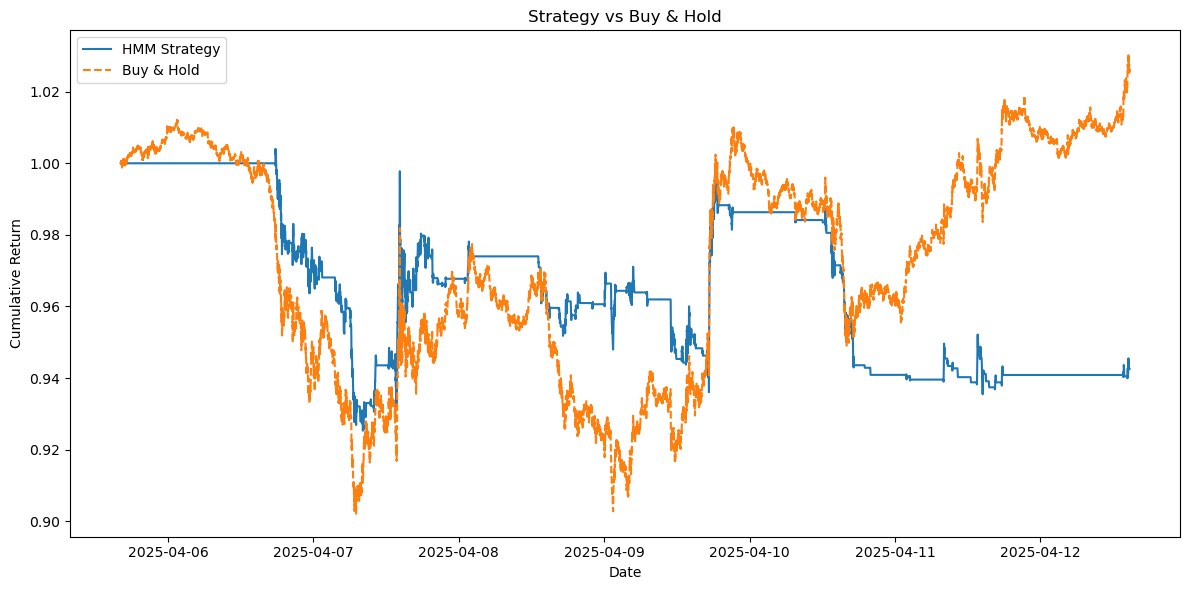

In [11]:

plt.figure(figsize=(12, 6))
plt.plot(global_df['start_time'], cumulative, label='HMM Strategy')
plt.plot(global_df['start_time'], buy_hold, label='Buy & Hold', linestyle='--')
plt.title("Strategy vs Buy & Hold")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.tight_layout()
plt.show()
